In [1]:
from dblayer import *

connect = PostgreSQLConnectionInfo(
    user = 'postgres',
    pwd = 'postgres',
    host = 'localhost',
    port = '5432',
    dbname = 'citydb'
    )

In [2]:
from dblayer.sim.pandangas import *

pg_reader = PandaNGasModelDBReader( connect )

In [3]:
net = pg_reader.get_net( network_id = 3000 )

In [4]:
net

This pandangas network includes the following parameter tables:
   - load (123 elements)
   - pipe (287 elements)
   - feeder (2 elements)
   - bus (277 elements)

In [5]:
db_access = DBAccess()
db_access.connect_to_citydb(connect)

In [6]:
RoundPipe = db_access.map_citydb_object_class( 'RoundPipe',
    table_name='utn9_ntw_feat_distrib_elem_pipe_round', schema='citydb_view' 
    )

NetworkToFeature = db_access.map_citydb_object_class( 'NetworkToFeature',
    table_name='utn9_network_to_network_feature', schema='citydb', user_defined = True
    )

Scenario = db_access.map_citydb_object_class( 'Scenario',
    table_name='scn2_scenario', schema='citydb_view'
    )

ScenarioParameterTimeSeries = db_access.map_citydb_object_class( 'ScenarioParameterTimeSeries',
    table_name='scn2_scenario_parameter_ts', schema='citydb_view', user_defined = True
    )

In [7]:
pipes_db_data = db_access.join_citydb_objects(
    [ 'RoundPipe', 'ScenarioParameterTimeSeries' ], 
    conditions = [
        NetworkToFeature.network_id == 3000,
        Scenario.name == 'GasGridSimResults',
        RoundPipe.id == NetworkToFeature.network_feature_id,
        ScenarioParameterTimeSeries.cityobject_id == RoundPipe.id,
        Scenario.id == ScenarioParameterTimeSeries.scenario_id
        ]
    )

In [8]:
from math import *

pipes_m_dot = {}

for data in pipes_db_data:
    
    pipe = data[0]
    scenario_param_ts = data[1]
    
    pipes_m_dot[pipe.name] = [ log1p( fabs( float(val) ) ) for val in scenario_param_ts.ts_values_array ]

In [9]:
time_start = pipes_db_data[0][1].ts_temporal_extent_begin
time_interval = int( pipes_db_data[0][1].ts_time_interval )
time_unit = pipes_db_data[0][1].ts_time_interval_unit

In [10]:
from pandangas.topology import create_nxgraph

g = create_nxgraph( net ).to_undirected()

In [11]:
nodes_pos = { n.name: pg_reader.geom_to_point2d( n.geom ).list() for n in pg_reader.network_nodes }
nodes_pos_x = [ p[0] for n, p in nodes_pos.items() ]
nodes_pos_y = [ p[1] for n, p in nodes_pos.items() ]

In [13]:
def get_pipe_name( node_name1, node_name2 ):
    node_id1_str = node_name1[8:]
    node_id2_str = node_name2[8:]
    
    if int( node_id1_str ) < int( node_id2_str ):
        return 'gas_pipe{}-{}'.format( node_id1_str, node_id2_str )
    else:
        return 'gas_pipe{}-{}'.format( node_id2_str, node_id1_str )

In [14]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import imageio
from pytimeparse.timeparse import timeparse
from datetime import timedelta

In [15]:
def animate_pipes_m_dot(figure, i):
    figure.clear()

    time_delta = timedelta( seconds = timeparse( '{delta}{unit}'.format( delta=i*time_interval, unit=time_unit ) ) )
    figure.suptitle( str( time_start + time_delta ) )
    
    edge_color_list = [ pipes_m_dot[ get_pipe_name(e[0],e[1]) ][i] for e in g.edges ]
    nx.draw( g, nodes_pos, edge_color=edge_color_list, edge_cmap=plt.cm.coolwarm, edge_vmin=0, edge_vmax=0.02, width=1, node_size=15 )

    figure.canvas.draw()
    w, h = figure.canvas.get_width_height()

    image_array = np.frombuffer( figure.canvas.tostring_rgb(), dtype='uint8' )
    return image_array.reshape( ( h, w, 3 ) )

In [16]:
%%capture

fig, ax = plt.subplots()
ax.set_xlim( ( min(nodes_pos_x), max(nodes_pos_x) ) )
ax.set_ylim( ( min(nodes_pos_y), max(nodes_pos_y) ) )

imageio.mimsave( './img/pipes_m_dot.gif', [ animate_pipes_m_dot(fig, i) for i in range(3,9) ], fps=2 )

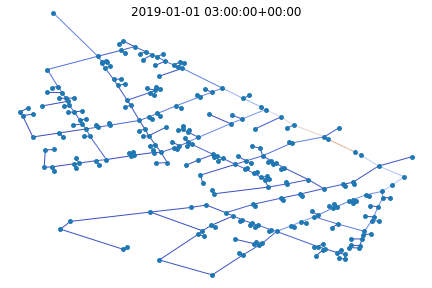

In [17]:
from IPython.display import Image
Image(filename="./img/pipes_m_dot.gif")